In [7]:
import torch
import clip
from PIL import Image
import os

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:39<00:00, 9.07MiB/s]


## Simple Example

In [10]:
image = preprocess(Image.open("assets/dog-cat.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.04565 0.44    0.514  ]]


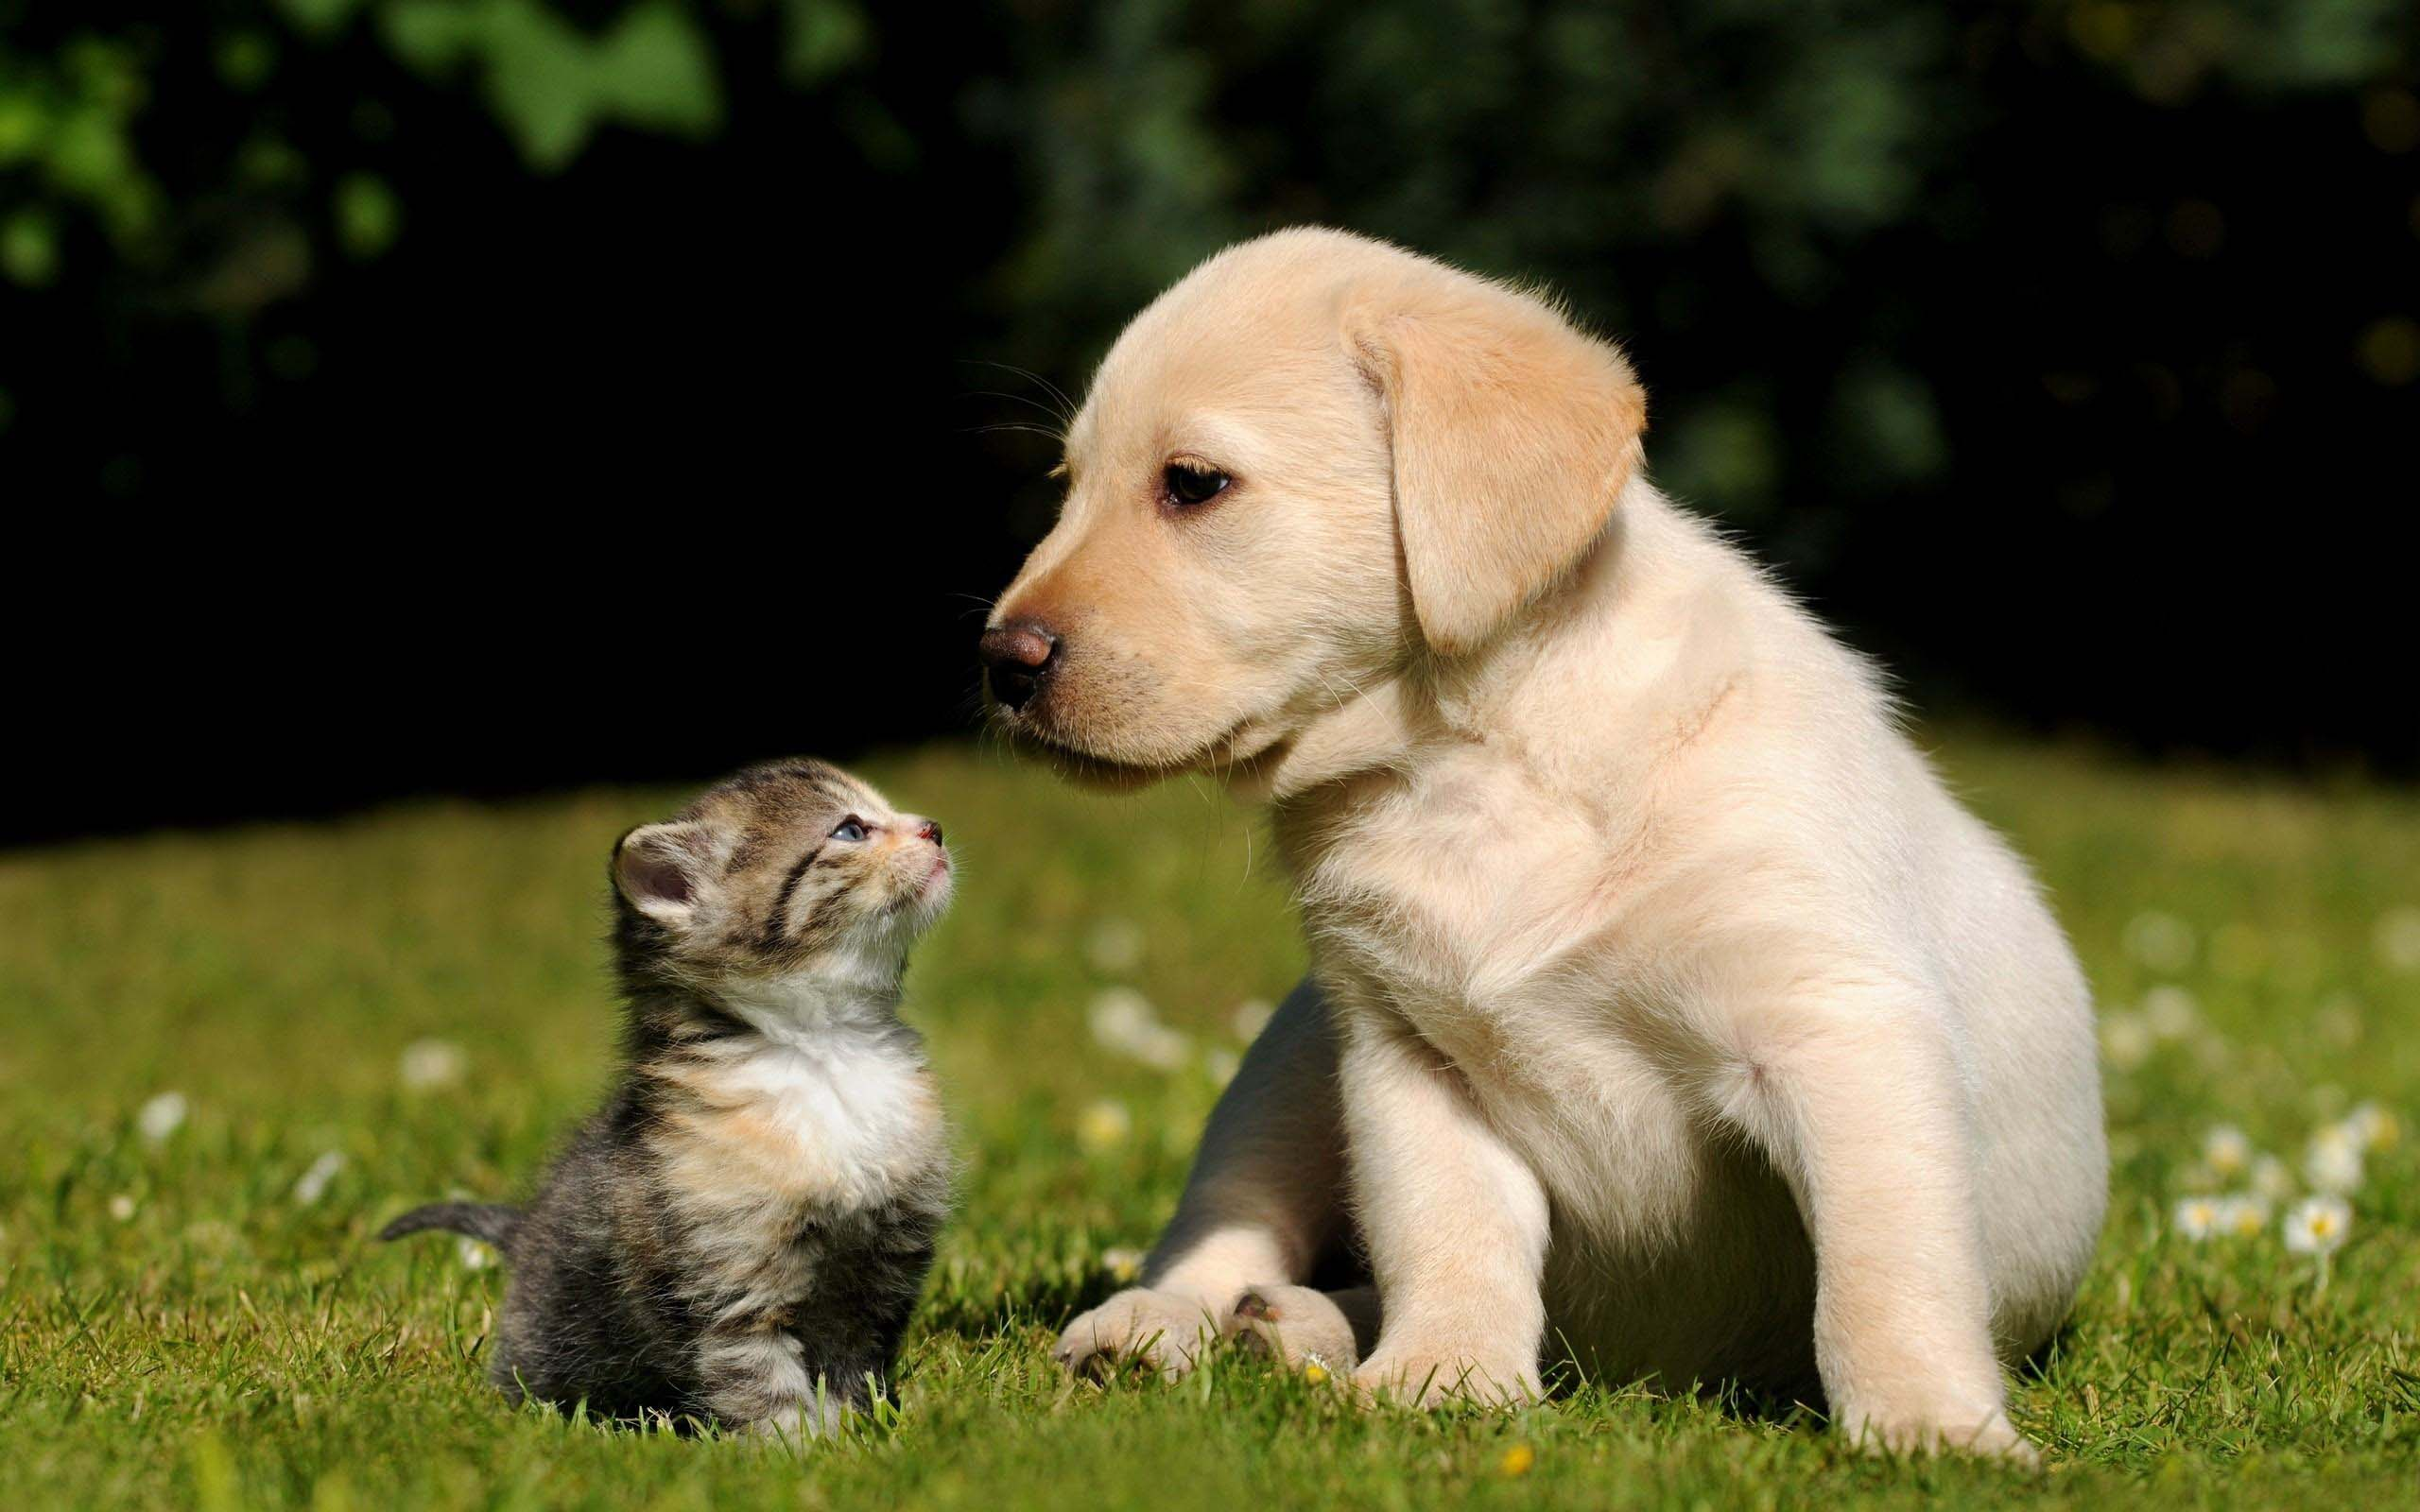

In [11]:

from IPython.display import Image 
img = Image("assets/dog-cat.jpg")
display(img)

## Zero-Shot Prediction

In [12]:
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3638]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

Files already downloaded and verified

Top predictions:

    sweet_pepper: 30.74%
           plate: 7.30%
            crab: 6.65%
            worm: 5.34%
         lobster: 5.10%


## Linear-probe evaluation

In [8]:
# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:10<00:00,  9.49it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        51300     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+05    |proj g|=  7.66181D+02


 This problem is unconstrained.



At iterate   50    f=  3.36314D+04    |proj g|=  7.18212D+02

At iterate  100    f=  2.92122D+04    |proj g|=  3.95485D+02

At iterate  150    f=  2.83662D+04    |proj g|=  2.68255D+02

At iterate  200    f=  2.81668D+04    |proj g|=  2.56258D+01

At iterate  250    f=  2.81333D+04    |proj g|=  2.03132D+01

At iterate  300    f=  2.81243D+04    |proj g|=  1.58896D+01

At iterate  350    f=  2.81208D+04    |proj g|=  7.66017D+00

At iterate  400    f=  2.81187D+04    |proj g|=  9.70093D+00

At iterate  450    f=  2.81133D+04    |proj g|=  2.95119D+01

At iterate  500    f=  2.81015D+04    |proj g|=  4.45942D+01

At iterate  550    f=  2.80928D+04    |proj g|=  3.62454D+01

At iterate  600    f=  2.80872D+04    |proj g|=  7.27652D+00

At iterate  650    f=  2.80861D+04    |proj g|=  1.18912D+01

At iterate  700    f=  2.80859D+04    |proj g|=  3.37697D+00

At iterate  750    f=  2.80858D+04    |proj g|=  1.35538D+00

At iterate  800    f=  2.80856D+04    |proj g|=  6.74465D+00

At iter

/home/ml/suruchi/anaconda3/envs/bishwash/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min finished
